# Week 6 - Machine Learning and Casual Inference

In this notebook we will walk through methods that combine machine learning and causal inference in contexts where the main goal is to isolate a causal effect.

The main purpose of this notebook is to learn how to practically implement the methods you saw in class and to think about the scenarios in which these methods are useful.


## Estimating the Gender Wage Gap and Child Penalty

In the first 3 exercises we will try to estimate the **gender wage gap** and the effect of having a child on earnings, which have been a hot topic in economic research and among policyamkers for a while now. 

We will do this using data from the 2018 Current Population Survey (CPS) in the US. In particular, we will use the version of the CPS provided by the [NBER](https://www.nber.org).

The *raw* regressions of reference is the following: 

<center>$y_i = \beta_0 + \beta_1 female_i + \varepsilon_i $</center>
.
<center>$y_i = \delta_0 + \delta_1 child_i + \varepsilon_i $</center>

where $y_i$ is one of the labor outcomes that we will define below and $female_i$ is a dummy for being a woman, and $child_i$ is a dummy equal to 1 if individual $i$ has a child.

**Suppose that $y_i$ is hourly wage, what can be a threat to a causal interpretation of $\beta_1$?**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col


style.use("fivethirtyeight")

In [3]:
df = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")
#we take subset of data just to reduce computation time
df = df.sample(30000, replace=False, random_state=0)
pd.read_stata('https://www.nber.org/morg/annual/morg18.dta', iterator=True).variable_labels()

{'hhid': 'Household ID',
 'intmonth': 'Interview Month',
 'hurespli': 'Line Number of Respondent',
 'hrhtype': 'Household Type',
 'minsamp': 'Month in sample (4 & 8 are departing)',
 'hrlonglk': 'Longitudinal Link Indicator',
 'hrsample': 'Sample indentifier',
 'hrhhid2': 'Household ID (partII)',
 'serial': 'Serial suffix',
 'hhnum': 'Household number',
 'stfips': 'State FIPS code',
 'cbsafips': 'Metropolitan CBSA FIPS code',
 'county': 'FIPS County Code',
 'centcity': 'Principal/Central city status',
 'smsastat': 'Metropolitan status code',
 'icntcity': 'Individual principal/central city code',
 'smsa04': 'Metropolitan Area (CBSA) size code',
 'relref95': 'Relationship to reference person',
 'age': 'Age',
 'spouse': "Spouse's line number",
 'sex': 'Sex',
 'grade92': 'Highest grade completed',
 'race': 'Race',
 'ethnic': 'Ethnicity',
 'lineno': "Person's Line Number",
 'famnum': 'Family number',
 'pfamrel': 'Primary family relationship',
 'marital': 'Marital status',
 'prpertyp': 'Type

In [4]:
df.head()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


In [5]:
# d variable:
df["female"] = (df['sex']==2).astype('int')
df['child'] = (df['ownchild']>0).astype('int')

# y variable:
df["log_earn"] = np.log(df['earnwke'])
df["log_earn"][np.isinf(df['log_earn'])] = np.nan

# hours (usual):
df["log_uhours"] = np.log(df['uhourse'])
df["log_uhours"][np.isinf(df['log_uhours'])] = np.nan

# hours (last week):
df["log_hourslw"] = np.log(df.hourslw)
df["log_hourslw"][np.isinf(df.log_hourslw)] = np.nan

# wage = earnigns / hours
df["log_wageu"] = df['log_earn'] - df['log_uhours']

In [4]:
print(df.female.value_counts())
print(df.child.value_counts())

1    15624
0    14376
Name: female, dtype: int64
0    22622
1     7378
Name: child, dtype: int64


**How would you try to isolate the effect of gender? Which of the techniques that we saw in class would you use here?**

*For isolating the gender wage gap we will use the propensity score matchin. This will allow us to compare individuals that are equally likely to be classified as women, given their characteristics. This way we compare individuals that are similar in those characteristics that are correlated with gender, obtaining a de-biased estimate of the gender wage gap.*

## Propensity Score Matching

In this part we will focus on the estimation of the gender wage gap. We will focus on hourly wage ($log\_wageu$) as main outcome of interest.

In [5]:
olsf = smf.ols("log_wageu~female", df).fit(cov_type='hc1')
ols2f = smf.ols('log_wageu ~ female + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)', df).fit(cov_type='hc1')

print(summary_col([olsf, ols2f], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['female']))


                                                                                                                         log_wageu I    log_wageu II  
------------------------------------------------------------------------------------------------------------------------------------------------------
female                                                                                                                   -0.169      -0.110           
                                                                                                                         (0.010)     (0.012)          
C(occ2012)[T.4400.0]                                                                                                                 -1.012           
                                                                                                                                     (0.319)          
C(occ2012)[T.1550.0]                                                                         

**How would you interpret the coefficient on female?**

*Recall that the outcome is in logs. This implies that women earn from 11% to 17% less per hour than men.*

### Prepare variables for ML

In [6]:
df.shape

(30000, 104)

In [7]:
cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012', 'marital', 'smsa04', 'prcitshp', 'chldpres']
df2 = df.dropna(subset=['female', 'log_wageu'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
df2.shape

(13052, 104)

In [8]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [9]:
D = df2['female']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

### Calculate Propensity Scores

Recall that propensity scores are just the probability of being treated (in this case of being women) given the values of the predictors:

<center>$\hat{Female}(X) = Pr(Female | X)$</center>

But this is basically a prediction problem that we can solve using machine learning.

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_a, X_b, D_a, D_b, y_a, y_b= train_test_split(X, D, y, test_size=0.5)
X_atr, X_ats, X_btr, X_bts, D_atr, D_ats, D_btr, D_bts = train_test_split(X_a, X_b, D_a, D_b, test_size=0.2)

xgb_a = XGBClassifier()
xgb_b = XGBClassifier()

xgb_a.fit(X_atr, D_atr)
D_hat_a = xgb_a.predict(X_ats)
xgb_b.fit(X_btr, D_btr)
D_hat_b = xgb_b.predict(X_bts)


print('Accuracy Score on Test Set')
print('Sample A: %f' % accuracy_score(D_hat_a, D_ats))
print('Sample B: %f' % accuracy_score(D_hat_b, D_bts))

[13:33:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score on Test Set
Sample A: 0.736600
Sample B: 0.741960


We calculate propensity scores by cross-predicting the probability of being female across the two samples.

In [11]:
pscore_b = xgb_a.predict_proba(X_b)[:,1]
pscore_a = xgb_b.predict_proba(X_a)[:,1]

D = D_a.append(D_b) 
y = y_a.append(y_b)
pscores = np.concatenate((pscore_a, pscore_b))
data = np.array([y,D,pscores]).T
pscores_df = pd.DataFrame(data=data,columns=['log_hourslw',"female", "pscore"])

pscores_df.head()

,log_hourslw,female,pscore
0,2.732743,1.0,0.880328
1,3.968110,1.0,0.443046
2,2.169054,0.0,0.092620
3,2.484907,0.0,0.064581
4,3.117773,1.0,0.207691


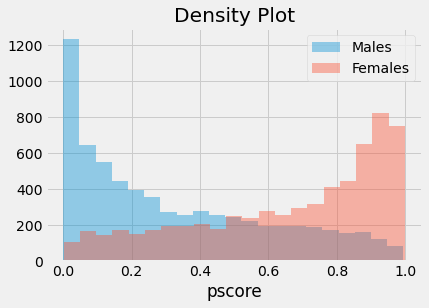

In [12]:
sns.distplot(pscores_df.query("female==0")["pscore"], kde=False, label="Males")
sns.distplot(pscores_df.query("female==1")["pscore"], kde=False, label="Females")
plt.title("Density Plot")
plt.legend();

### Estimate Gender Wage Gap using Propensity Scores

In [13]:
pscores_df['bins'] = pd.cut(pscores_df['pscore'], bins = 50, labels=range(1,51))
pscores_df['bins'] = pscores_df['bins'].astype('str')
pscores_df.head()

,log_hourslw,female,pscore,bins
0,2.732743,1.0,0.880328,45
1,3.968110,1.0,0.443046,23
2,2.169054,0.0,0.092620,5
3,2.484907,0.0,0.064581,4
4,3.117773,1.0,0.207691,11


**What are we comparing within each bin?**

*As mentioned above, we are comparing individuals that are equally likely to be classified as women based on a set of predictors.*

In [14]:
pscores_df = pscores_df.groupby(['bins', 'female']).mean()
pscores_df.head()

log_hourslw    pscore
bins female                       
1    0.0        2.954329  0.010018
     1.0        2.777398  0.011694
10   0.0        3.208918  0.190200
     1.0        3.011839  0.189179
11   0.0        3.060339  0.210128

In [15]:
pscores_df['diffs'] = np.nan 

for idx in pscores_df.index.levels[0]:
    pscores_df.diffs[idx][1] = pscores_df.log_hourslw[idx][1] - pscores_df.log_hourslw[idx][0]
    
ate_df = pscores_df.dropna()
ate_df.head()

,,log_hourslw,pscore,diffs
bins,female,,,
1,1.0,2.777398,0.011694,-0.176931
10,1.0,3.011839,0.189179,-0.197079
11,1.0,2.964023,0.209489,-0.096316
12,1.0,3.077028,0.229714,-0.092413
13,1.0,2.974197,0.249114,-0.178761


In [16]:
ATE = ate_df.diffs.mean()
print(ATE)

-0.13033719462056131


**How does this compare to the previous estimate?**

*This estimate is in line with the ones found above, and it hints towards a gender wage gap of 13% percent.*

## Double Machine Learning

In this second exercise we will focus on the effect of having a child on hourly wages for women. The regression we will try to estimate is the following: 

$$log\_wageu_i=\delta_0 + \delta_1 child_i+ f(x_i) +\varepsilon_i$$ 


**Generally, in which cases would you use double ML? In your opinion is this a good setting?**

*Double ml is very useful in two settings:*

*- When the dataset is very high-dimensional (there is a large number of covariates) as it makes the estimation of an unbiased effect feasible or less computationally costly.*

*- If we expect strong non-linearities in the relationship between the covariates and the treatment and/or the outcome*

*This setting is a good example for the application of double ml because there is a large number of covariates that make the estimation of the coefficient, controlling for them, computationally costly.*

In [17]:
df_fem = df[df['female']==1]

olsc = smf.ols("log_wageu ~ child", df_fem).fit(cov_type='hc1')
ols2c = smf.ols('log_wageu ~ child + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)', df_fem).fit(cov_type='hc1')

print(summary_col([olsc, ols2c], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['child']))


                                                                                                                         log_wageu I log_wageu II
-------------------------------------------------------------------------------------------------------------------------------------------------
child                                                                                                                    0.079       0.051       
                                                                                                                         (0.015)     (0.014)     
C(occ2012)[T.4400.0]                                                                                                                 -0.926      
                                                                                                                                     (0.396)     
C(cbsafips)[T.16820]                                                                                                       

**How would you interpret the coefficient on having a child?**

*As before, we have a log outcome, meaning that hevin a child increases hourly wages by 5% to 8% percent.*

### Prepare Variables for ML

In [18]:
cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012']
df2 = df_fem.dropna(subset=['log_wageu', 'child'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
    
print(df2.shape)
print(df2.child.value_counts())

(6413, 104)
0    4294
1    2119
Name: child, dtype: int64


In [19]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [20]:
D = df2['child']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

### Step 1. Predict $y$ and $D$ from $X$ using Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, mean_squared_error)

rfc_a = RandomForestClassifier(n_estimators=100, max_depth =30, random_state=42)
rfc_b = RandomForestClassifier(n_estimators=100,  max_depth =30, random_state=42)

rfr_a = RandomForestRegressor(n_estimators=100, max_depth =30, random_state=42)
rfr_b = RandomForestRegressor(n_estimators=100,  max_depth =30, random_state=42)


X_a, X_b, D_a, D_b, y_a, y_b= train_test_split(X, D, y, test_size=0.5)
X_atr, X_ats, D_atr, D_ats, y_atr, y_ats, = train_test_split(X_a, D_a, y_a, test_size=0.2)
X_btr, X_bts, D_btr, D_bts, y_btr, y_bts = train_test_split(X_b, D_b, y_b, test_size=0.2)

#### Train the models

In [22]:
rfc_a.fit(X_atr, D_atr)
D_hat_a = rfc_a.predict(X_ats)
rfc_b.fit(X_btr, D_btr)
D_hat_b = rfc_b.predict(X_bts)


print('F1 Score on Test Set')
print('Sample A: %f' % f1_score(D_hat_a, D_ats))
print('Sample B: %f' % f1_score(D_hat_b, D_bts))

F1 Score on Test Set
Sample A: 0.594595
Sample B: 0.565657


In [23]:
rfr_a.fit(X_atr, y_atr)
y_hat_a = rfr_a.predict(X_ats)
rfr_b.fit(X_btr, y_btr)
y_hat_b = rfr_b.predict(X_bts)


print('RMSE on Test Set')
print('Sample A: %f' % np.sqrt(mean_squared_error(y_hat_a, y_ats)))
print('Sample B: %f' % np.sqrt(mean_squared_error(y_hat_b, y_bts)))

RMSE on Test Set
Sample A: 0.577742
Sample B: 0.578958


#### Cross predict $D$ and $y$

In [24]:
D_hat_a = rfc_b.predict(X_a)
D_hat_b = rfc_a.predict(X_b)

y_hat_a = rfr_b.predict(X_a)
y_hat_b = rfr_a.predict(X_b)

### Step 2. Compute residuals for having a child and hourly wages

Recall that residuals for variable $Z$ are computed in the following way: 
 
 $$\tilde Z_i = Z_i - \hat Z_i$$

In [25]:
D = D_a.append(D_b) 
Dhat = np.concatenate((D_hat_a, D_hat_b))
y = y_a.append(y_b)
yhat = np.concatenate((y_hat_a, y_hat_b))
data = np.array([y,D,yhat, Dhat]).T
df_dml = pd.DataFrame(data=data,columns=['y',"D", "yhat", 'Dhat'])

df_dml['log_wageu'] = df_dml.y - df_dml.yhat
df_dml['child'] = df_dml.D - df_dml.Dhat

df_dml.head()

,y,D,yhat,Dhat,log_wageu,child
0,2.468947,0.0,2.773299,1.0,-0.304352,-1.0
1,3.767436,1.0,3.219988,0.0,0.547448,1.0
2,3.295837,1.0,3.351513,0.0,-0.055676,1.0
3,2.847812,0.0,3.448480,0.0,-0.600668,0.0
4,2.667228,0.0,2.817082,0.0,-0.149854,0.0


### Step 3. Run a Regression of the residualized variables to compute DML estimats

In [26]:
dml = smf.ols('log_wageu ~ child', df_dml).fit(cov_type='hc1')
print(summary_col([olsc, ols2c, dml], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['child']))


                                                                                                                         log_wageu I log_wageu II log_wageu III
---------------------------------------------------------------------------------------------------------------------------------------------------------------
child                                                                                                                    0.079       0.051        -0.012       
                                                                                                                         (0.015)     (0.014)      (0.012)      
C(occ2012)[T.4400.0]                                                                                                                 -0.926                    
                                                                                                                                     (0.396)                   
C(cbsafips)[T.16820]                   

## !!NEW SECTION: Double ML using *econml*

Now we will see how to implement double machine learning with a new package *EconML* (documentation [here](https://github.com/microsoft/EconML)).

In [ ]:
#!pip install econml

### Prepare Variables

In [6]:
df_fem = df[df['female']==1]

cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012']
df2 = df_fem.dropna(subset=['log_wageu', 'child'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
    
print(df2.shape)
print(df2.child.value_counts())

(6413, 104)
0    4294
1    2119
Name: child, dtype: int64


In [7]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() and feature importance
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [8]:
D = df2['child']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, mean_squared_error)

X_tr, X_ts, D_tr, D_ts, y_tr, y_ts= train_test_split(X, D, y, test_size=0.2)

We will use the module *CausalForestDML* ([link here](https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML)).

In [28]:
from econml.dml import CausalForestDML
from sklearn.linear_model import Lasso, LogisticRegression

In [43]:
# Use defaults
est = CausalForestDML()
# Or specify hyperparameters
est = CausalForestDML(criterion='mse', n_estimators=500,       
                      min_samples_leaf=10, 
                      max_depth=10, max_samples=0.5,
                      discrete_treatment=True,
                      model_t=LogisticRegression(), model_y=Lasso())

In [44]:
est.fit(y_tr,D_tr, X=X_tr)

This allows us to estimate the treatment effect for each observation (we will do it in the test set). Using *effect_interval* we can also compute confidence intervals for each estimate with bootstrap.

In [45]:
# treatment effect for each test-set observation
treatment_effects = est.effect(X_ts)


# Confidence intervals via Bootstrap-of-Little-Bags for forests
lb, ub = est.effect_interval(X_ts, alpha=0.05)

As an example, lets explore the treatment effect for the first observation.

In [46]:
treatment_effects[0]

You can also visualize the average treatment effect on the whole training sample, its standard error.

In [49]:
print("ATE: ", est.ate_)
print("Standard Error: ", est.ate_stderr_)

ATE:  [0.07054053]
Standard Error:  [0.01776173]


## Heterogenous Treatment Effects

In this part we will again assume that the treatment is having a child and we want to investigate the characteristics of women whose earnings are most affected by having a child.

### Step 1. Divide the sample in "treated" and "untreated"

In [27]:
df_treat = df2.loc[df2['child']==1]
df_control = df2.loc[df2['child']==0]

### Step 2. Train two models to predict $y$ based on the covariates, one for each datasets using XGBoost

In [28]:
from xgboost import XGBRegressor

Xt_train, Xt_test, yt_train, yt_test = train_test_split(df_treat[cat_vars + cont_vars], df_treat['log_wageu'], test_size=0.3)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(df_control[cat_vars + cont_vars], df_control['log_wageu'], test_size=0.3)

xgbr_treat = XGBRegressor()
xgbr_control = XGBRegressor()

xgbr_treat.fit(Xt_train, yt_train)
xgbr_control.fit(Xc_train, yc_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Step 3. Form predicted outcomes for each datapoint in the test set, using both models

In [29]:
test_set = Xt_test.append(Xc_test)

yhat_treat = xgbr_treat.predict(test_set)
yhat_control = xgbr_control.predict(test_set)

### Step 4. Compute the treatment effect for each observation using the predicted values

In [30]:
test_set['treat_effect'] = yhat_treat - yhat_control
test_set.head()

,race,cbsafips,smsastat,grade92,unionmme,unioncov,ind02,occ2012,log_hourslw,age,treat_effect
59043,0.0,30.0,0.0,9.0,0.0,0.0,159.0,241.0,3.555348,29.0,0.010866
282089,0.0,247.0,0.0,14.0,0.0,0.0,78.0,60.0,3.555348,37.0,-0.516862
169947,8.0,53.0,0.0,12.0,0.0,0.0,162.0,114.0,3.871201,51.0,-0.232360
148569,0.0,107.0,0.0,4.0,0.0,0.0,92.0,158.0,2.995732,43.0,-0.188450
289572,0.0,147.0,0.0,11.0,0.0,0.0,110.0,114.0,3.871201,48.0,-0.109595


In [31]:
test_set = test_set.sort_values('treat_effect', axis=0)
test_set.head()

,race,cbsafips,smsastat,grade92,unionmme,unioncov,ind02,occ2012,log_hourslw,age,treat_effect
286052,5.0,70.0,0.0,14.0,0.0,0.0,92.0,68.0,3.218876,77.0,-2.110609
214893,8.0,0.0,0.0,13.0,0.0,0.0,121.0,202.0,3.688879,40.0,-1.741491
216818,8.0,0.0,0.0,12.0,0.0,0.0,60.0,186.0,3.663562,43.0,-1.701088
249332,0.0,138.0,0.0,12.0,0.0,0.0,192.0,179.0,1.098612,62.0,-1.670660
42130,12.0,3.0,0.0,12.0,0.0,0.0,180.0,184.0,3.401197,32.0,-1.541899


We can also visualize the most important predictors for having a large treatment effect.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

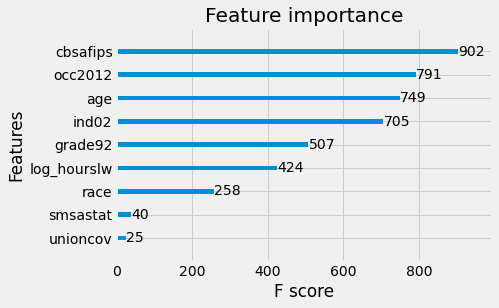

In [32]:
from xgboost import plot_importance

xgb = XGBRegressor()
xgb.fit(test_set[cat_vars + cont_vars], test_set['treat_effect'])

plot_importance(xgb)

**What would be an ideal setting to investigate heterogenous treatment effects?**

*Generally, the estimation of heterogenous treatment effects is very important in settings where the treatment is an intervention which can be targetd. Consider for instance the use of a new drug or medical treatment. Medical practitioners would like to give it to individuals who are likely to respond more positely to it. Therefore, estimation of HTE in the trials is fundamental for a correct allocation of the new drug/treatment.*

## Synthetic Control Method

In this part we will replicate the analysis of the paper from class on the anti-tobacco legislation ([Abadie et al., 2010](https://economics.mit.edu/files/11859)). We will investigate the effect of this law implemented in California in 1988 on cigarettes sales. The (raw) reference regression is the following:

<center>$sales_s = \beta_0 + \beta_1 law_s + \varepsilon_s$</center>

where $sales_s$ is per capita cigarettes sales in sales $s$ and $law_s$ is a dummy equal to 1 if the law was passed in that state. 

In [33]:
df=pd.read_csv('https://raw.githubusercontent.com/OscarEngelbrektson/SyntheticControlMethods/3f496b36ed46c4e5c1e08ce6e903013e6eeb29df/examples/datasets/smoking_data.csv')
df['california'] = (df['state']=='California').astype('int')
df['post'] = (df['year']>1988).astype('int')
df['law'] = df['california']*df['post']
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,post,law
0,Alabama,1970.0,89.8,NaN,NaN,0.178862,39.6,0,0,0
1,Alabama,1971.0,95.4,NaN,NaN,0.179928,42.7,0,0,0
2,Alabama,1972.0,101.1,9.498476,NaN,0.180994,42.3,0,0,0
3,Alabama,1973.0,102.9,9.550107,NaN,0.182060,42.1,0,0,0
4,Alabama,1974.0,108.2,9.537163,NaN,0.183126,43.1,0,0,0


In [34]:
ols = smf.ols('cigsale ~ law', data =df).fit(cov_type='hc1')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cigsale   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     290.2
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.74e-58
Time:                        13:34:16   Log-Likelihood:                -5914.0
No. Observations:                1209   AIC:                         1.183e+04
Df Residuals:                    1207   BIC:                         1.184e+04
Df Model:                           1                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.4801      0.936    127.615      0.000     117.645     121.315
law          -59.1301      3.471    -17.036      0.000     -65.933     -52.327
==============================================================================
Omnibus:                      416.310   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1837.171
Skew:                           1.575   Prob(JB):                         0.00
Kurtosis:                       8.153   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**Can we interpret the coefficient on california as causal? Why?**

*No because it is possible that California already had lower levels of cigarattes sales even before the law was passed.*

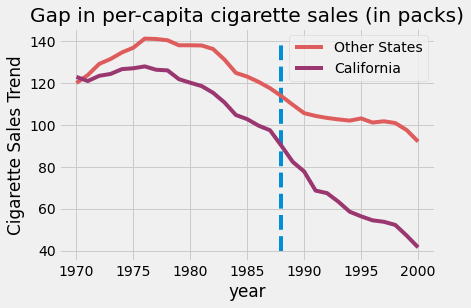

In [35]:
palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='year', y='cigsale', hue='california', palette=palette, ci=None)

plot.vlines(x=1988, ymin=40, ymax=140, linestyle="dashed")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plot.legend_.set_title('')
new_labels = ['Other States', 'California']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)

**Could we use a difference in differences design in this context?**

*This is a not an ideal context to use difference in differences because the parallel trends assumption is not satisfied. Indeed, while the cigarettes sales start from the same levels in 1970 in California and other states, the trends diverge really right after that year, with California displaying a flat and decreasing trend.*

You can find the refernece material for the python package on the synthetic control method at this [link](https://github.com/OscarEngelbrektson/SyntheticControlMethods)

In [36]:
from SyntheticControlMethods import Synth
del df['california']
sc = Synth(df, "cigsale", "state", "year", 1989, "California", n_optim=10, pen="auto")


ModuleNotFoundError: No module named 'SyntheticControlMethods'

In [ ]:
sc.plot(["original"], treated_label="California", 
            synth_label="Synthetic California", treatment_label="Proposal 99")

In [ ]:
print(sc.original_data.weight_df)